In [100]:
from datetime import datetime, timedelta
import os
import time
import requests
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import doctor
import math
from IPython.display import clear_output
import main
import seaborn as sea
import matplotlib.patches as patches
import matplotlib as mpl
import ryan_tools as rt
import keras as kr

### Open

In [2]:
def plot_candles(candles, signal, fig, ax):
    def add_rectangle(i, open_, close,low, high, ax, sig):
        x = i - .5
        y = min(open_, close)
        height = abs(open_ - close)
        if sig == 'buy':
            color = 'green'
            hatch = 'x'
        if sig == 'sell':
            color = 'red'
            hatch = ''
            
        if sig == 'wait':
            color = 'orange'
            hatch = ''
        ax.add_patch(patches.Rectangle((x, y), .9, height,
                                       fill = open_ <= close, facecolor = color,
                                       edgecolor = color, hatch = hatch ))
        top = max(open_,close)
        bottom = min(open_,close)

        if low < bottom:
            ax.add_line(mpl.lines.Line2D([i,i], [low, bottom], color = color) )

            
        if high > top:
            ax.add_line(mpl.lines.Line2D([i,i], [high, top], color = color) )

        
    for i, index in enumerate(candles.index):
        sig = signal.loc[index]
        row = candles.loc[index]
        add_rectangle(i, row['open'], row['close'],row['low'], row['high'],  ax, sig)
    ax.set_xlim(0, len(candles))
    ax.set_ylim(candles['close'].min() *.998, candles['close'].max() * 1.002)
    return ax

In [3]:
def chartio(gran = 60, cans = False, count = False):
    if type(cans) == type(False):
        cans = aba.get_candles(granularity= gran)
    if count == False:
        count = len(cans)
    mask = cans['open']< cans['close']
    signal = pd.Series(index = cans.index )
    signal.loc[mask] = 'buy'
    signal.loc[~mask] = 'sell'

    
    
    fig, (ax, sig_ax) = plt.subplots(nrows = 2, sharex= False)
    fig.set_size_inches(7, 9)
    plot_candles(cans[-count:], signal[-count:], fig, ax)
    ax.set_xticklabels(cans.index)
    ax2 = ax.twinx()
    cans.iloc[-count:]['volume'].plot(kind = 'bar', ax = ax2, alpha = 0.3)
    

    rsi = aba.get_rsi(cans['close'])
    macd = aba.get_macd(cans)
    rsi.plot(ax = sig_ax, alpha = 0.1)
    ax4 = sig_ax.twinx()
    macd[['macd', 'macd_signal']].plot(ax = ax4)
    plt.show()
    

In [4]:
aba = main.Abathor('LTC-USD')

In [5]:
observations = []

def get_random_candles():
    days = np.random.randint(1, 500)
    hours = np.random.randint(0, 12)
    minutes = np.random.randint(0,60)
    start = datetime.today() - timedelta(days = days, hours = hours, minutes = minutes )
    end = start + timedelta(seconds = 60 * 200)
    cans =  aba.get_candles(start, end)
    observations.append(cans)
    return cans

In [117]:
to_download = 1000
bar = rt.progress_bar(to_download)
for num in range(0, to_download):
    get_random_candles()
    bar.progress()

KeyboardInterrupt: 

In [118]:
def create_data(candle_list, candles_before = 10):
    X = []
    y = []
    ar = np.array
    bar = rt.progress_bar(len(candle_list))
    for candles in candle_list:
        bar.progress()
        changes = candles.copy()
        changes[['low', 'high', 'open', 'close', 'volume']] = np.log(changes[['low', 'high', 'open', 'close', 'volume']]).diff().bfill()

        for index in changes.index:
            change_percent = changes.loc[index, 'close']
            all_before = changes.loc[:index]
            amount = len(all_before)
            if amount > candles_before + 2:
                Xi = all_before.iloc[amount - (candles_before+ 2):amount-2]
                Xi = ar(Xi[['low', 'high', 'open', 'close', 'volume']].values)
                X.append(Xi)
                y.append(change_percent)
    X, y =  ar(X), ar(y)
    return X, y
    

In [198]:
def make_samples_even(X,y, target_ratio = .8 ):
    X = list(X)
    y = list(y)
    
    def get_ratio(y):
        total = len(y)
        wins = np.sum(y)
        losses = total - wins
        return wins/losses
    
    def add_another(X, y, windexes):
        to_add = np.random.choice(windexes)
        X.append(X[to_add])
        y.append(y[to_add])
    ratio = get_ratio(y)
    while ratio < target_ratio:
        windexes = [i for i,val in enumerate(y) if val==1]
        for num in range(0, 100):
            add_another(X, y, windexes)

        ratio = get_ratio(y)
        print(ratio)
        clear_output(True)
        
    return np.array(X), np.array(y)


In [195]:
candles_before = 25
X, Y = create_data(observations, candles_before)
temp = pd.DataFrame(Y, columns = ['y'])
mask = temp['y'] >= 0.005
temp.loc[mask, 'new_y'] = 1
temp.loc[~mask, 'new_y'] = 0
y = temp['new_y'].values


0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o> | 100.00 % 
Done: 448 Remaining: 1, Remaining Time: 0s


In [ ]:
X,y  = make_samples_even(X, y, 1 )

0.5793543980877006


In [208]:
def generate_model(X, y):
    model = kr.models.Sequential()
    model.add(kr.layers.LSTM(2**4, input_shape=X.shape[1:],return_sequences=True))
    #model.add(kr.layers.Dropout(0.3))
    model.add(kr.layers.LSTM(2**4))
    model.add(kr.layers.Dense(1))
    model.add(kr.layers.Activation('sigmoid'))
    #optimizer = kr.optimizers.RMSprop(lr=0.001)
    optimizer = kr.optimizers.Adam(0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

model = generate_model(X, y)

In [210]:
model.fit(X, y,batch_size=1000,  epochs=10, validation_split=0.30, verbose = 1)

Train on 45307 samples, validate on 19418 samples
Epoch 1/10
45307/45307 [==============================] - 4s 86us/step - loss: 0.1030 - val_loss: 2.8450
Epoch 2/10
45307/45307 [==============================] - 4s 82us/step - loss: 0.1022 - val_loss: 2.7853
Epoch 3/10
45307/45307 [==============================] - 4s 83us/step - loss: 0.1021 - val_loss: 2.8030
Epoch 4/10
45307/45307 [==============================] - 4s 81us/step - loss: 0.1020 - val_loss: 2.7735
Epoch 5/10
45307/45307 [==============================] - 4s 82us/step - loss: 0.1020 - val_loss: 2.8037
Epoch 6/10
23000/45307 [==============>...............] - ETA: 1s - loss: 0.0978

KeyboardInterrupt: 

In [144]:
def convert_cans_to_shape(cans):
    changes = candles.copy()
    changes[['low', 'high', 'open', 'close', 'volume']] = np.log(changes[['low', 'high', 'open', 'close', 'volume']]).diff().bfill()
    changes = changes[['low', 'high', 'open', 'close', 'volume']] 
    temp = changes.iloc[-candles_before:].values

    return np.array([temp])

Predictions
count    1.734000e+03
mean     1.245582e-01
std      2.355447e-01
min      4.620672e-08
25%      7.956323e-04
50%      9.971695e-03
75%      1.025401e-01
max      9.934995e-01
dtype: float64
y
count    1734.000000
mean        0.027682
std         0.164106
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64
Predictions vs y
green = y | red = preds


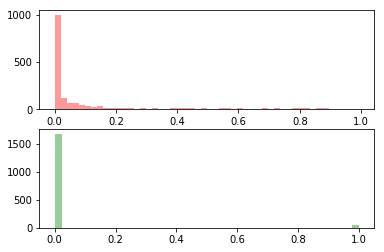

In [189]:
def evaluate(samples = 10):
    hidden_list = []
    bar = rt.progress_bar(samples)
    for num in range(0, samples):
        bar.progress()
        hidden_list.append(get_random_candles())
        
    X, Y = create_data(hidden_list, candles_before)
    temp = pd.DataFrame(Y, columns = ['y'])
    mask = temp['y'] >= 0.005
    temp.loc[mask, 'new_y'] = 1
    temp.loc[~mask, 'new_y'] = 0
    y = temp['new_y'].values

    
    preds = model.predict(X)
    print('Predictions')
    print(pd.Series(preds.reshape(len(preds))).describe())
    print('y')
    print(pd.Series(y).describe())
    print('Predictions vs y')
    fig, (ax, ax2) = plt.subplots(nrows= 2)
    sea.distplot(preds, kde = False, ax = ax, color = 'red')

    sea.distplot(y, kde = False, ax = ax2, color = 'green')
    print('green = y | red = preds')
    plt.show()
    
    comparison = pd.DataFrame()
    comparison['preds'] = preds.reshape(len(preds))
    comparison['preds'] = comparison['preds'].apply(lambda x: round(x, 4))
    comparison['y'] = temp['y']
    return preds, comparison

preds, comparison = evaluate()

In [190]:
comparison.describe()

,preds,y
count,1734.000000,1734.000000
mean,0.124558,0.000050
std,0.235546,0.003073
min,0.000000,-0.025522
25%,0.000800,-0.000245
50%,0.010000,0.000000
75%,0.102575,0.000472
max,0.993500,0.047504


In [193]:
comparison[comparison['preds'] > .9]

,preds,y
70,0.9436,-0.005828
81,0.9881,0.003827
84,0.9797,-0.025522
87,0.9241,0.005101
88,0.9772,-0.002413
110,0.9667,0.024239
112,0.9190,0.004608
123,0.9809,-0.005450
141,0.9106,-0.005510
175,0.9935,0.000000


In [172]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 16)            1408      
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 3,537
Trainable params: 3,537
Non-trainable params: 0
_________________________________________________________________


In [173]:
model.save('model.data')